In [1]:
import pandas as pd
import numpy as np
import csv
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Initialize dir path, filename and df vars
data_dir = "data/"
sso_fn = 'all_data_sso.csv'
ssq_fn = 'all_data_ssq.csv'
sso_data = ''
ssq_data = ''

In [3]:
# Load dataset
with open(data_dir + sso_fn, 'r') as f:
    sso_data = list(csv.reader(f, delimiter=','))
with open(data_dir + ssq_fn, 'r') as f:
    ssq_data = list(csv.reader(f, delimiter=','))
df = pd.DataFrame.from_records(sso_data[1:] + ssq_data[1:], columns=sso_data[0])
del sso_data
del ssq_data

# Turn categorical cols into dummy vars and concat
con_dummy = pd.get_dummies(df['condition'], drop_first=True, prefix='cond')
paint_dummy = pd.get_dummies(df['paint color'], drop_first=True, prefix='col')
title_dummy = pd.get_dummies(df['title status'], drop_first=True, prefix='title')
type_dummy = pd.get_dummies(df['type'], drop_first=True, prefix='type')
size_dummy = pd.get_dummies(df['size'], drop_first=True, prefix='size')
state_dummy = pd.get_dummies(df['state'], drop_first=True, prefix='state')
city_dummy = pd.get_dummies(df['city'], drop_first=True, prefix='city')

# Drop original cols that turned into dummys and concat respective dummies
df = pd.concat([df.drop(['condition', 'paint color', 'title status', 'type', 'size', 'city', 'state'], axis=1),\
                con_dummy, paint_dummy, title_dummy, type_dummy, state_dummy, city_dummy], axis = 1)

# Cast string nums to int in cols loaded from data,
df['price'] = df['price'].apply(int)
df['sso'] = df['sso'].apply(int)
df['postlen'] = df['postlen'].apply(int)
df['nthumbs'] = df['nthumbs'].apply(int)
df['year'] = df['year'].apply(int)
df.loc[df['odometer']!='None','odometer'] = df.loc[df['odometer']!='None', 'odometer'].apply(int)

# Drop rows that we know can't be true
error_price = len(df[df['price'] < 40000])
error_year = len(df[df['year'] < 1997])
df = df[df['price'] < 40000]
df = df[df['price'] > 1000]
df = df[df['year'] > 1997]

# Tranform year col now to age
df['age'] = 2018-df['year']
df['log_price'] = np.log(df['price'])
del df['year']

# Imput missing odometer data with median of known values
# Select non-missing odometer vals (and corresponding age)
odom = df.loc[df['odometer']!='None', ['age', 'odometer']]

# Keep track of an age_mile dict to map, and array to graph
age_mile = {}

for i in range(18):
    med = odom[odom['age'] == i]['odometer'].median()
    age_mile[str(i)] = med

df.loc[df['odometer'] == 'None','odometer'] =\
        df.loc[df['odometer'] == 'None', 'age'].apply(lambda x: age_mile[str(x)])

# Remove extreme odometer values we know is not possible
df = df[df['odometer'] < 380000]
df = df[df['odometer'] > 300]

In [4]:
# Split into 80/20, train/test (later train will actually be split into train/validation)
split_data, split_test = model_selection.train_test_split(df, random_state = 0)

In [52]:
# Create a copy of train df to do initial selections
play_df = split_data.copy()

# Normalize for preliminary effect size inspection
norm = lambda x: (x-x.mean())/x.std()
play_df['age'] = norm(play_df['age'])
play_df['age'] = np.exp(-1 * play_df['age'])
play_df['age'] = norm(play_df['age'])
play_df['nthumbs'] = norm(play_df['nthumbs'])
play_df['postlen'] = norm(play_df['postlen'])
play_df['odometer'] = norm(play_df['odometer'])
play_df['odometer'] = play_df['odometer'].apply(float)
play_df['odometer'] = np.exp(-1*play_df['odometer'])

/Users/amhoang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


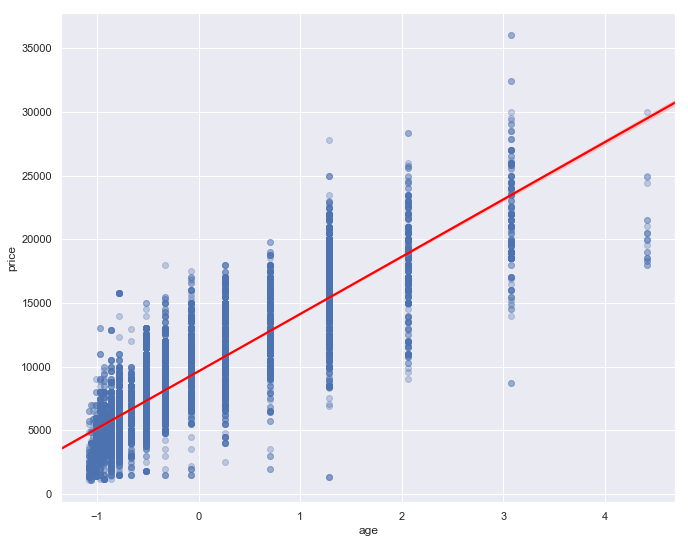

In [61]:
# sns.scatterplot(x='odometer', y='price', data=play_df)
f, ax = plt.subplots(figsize=(11, 9))
# sns.scatterplot(x='age', y='price', data=play_df, ax = ax)
sns.regplot(x='age', y='price', data = play_df, ax=ax, ci=85, line_kws={'color':'red'}, scatter_kws={'alpha':.3})
f.savefig('age.svg', format='svg')

In [11]:
# Initialize list of original vars, states, and city features to feature select

original_feats = ['sso', 'odometer', 'nthumbs', 'postlen', 'age',
       'cond_fair', 'cond_good', 'cond_like new', 'cond_new', 'cond_salvage',
       'cond_unknown', 'col_black', 'col_blue', 'col_brown', 'col_custom',
       'col_green', 'col_grey', 'col_orange', 'col_purple', 'col_red',
       'col_silver', 'col_unknown', 'col_white', 'col_yellow', 'title_clean',
       'title_lien', 'title_parts only', 'title_rebuilt', 'title_salvage',
       'title_unknown', 'type_SUV', 'type_coupe', 'type_hatchback',
       'type_mini-van', 'type_other', 'type_sedan', 'type_unknown', 'type_van',
       'type_wagon']

states_of_int = ['state_alaska',
       'state_arizona', 'state_arkansas', 'state_california', 'state_colorado',
       'state_connecticut', 'state_dc', 'state_delaware', 'state_florida',
       'state_georgia', 'state_idaho', 'state_illinois', 'state_indiana',
       'state_iowa', 'state_kansas', 'state_kentucky', 'state_louisiana',
       'state_maine', 'state_maryland', 'state_mass', 'state_michigan',
       'state_minnesota', 'state_mississippi', 'state_missouri',
       'state_montana', 'state_ncarolina', 'state_nebraska', 'state_nevada',
       'state_newjersey', 'state_newmexico', 'state_newyork',
       'state_nhampshire', 'state_northdakota', 'state_ohio', 'state_oklahoma',
       'state_oregon', 'state_pennsylvania', 'state_rhodeisland',
       'state_scarolina', 'state_southdakota', 'state_tennessee',
       'state_texas', 'state_utah', 'state_vermont', 'state_virginia',
       'state_washington', 'state_westvirginia', 'state_wisconsin',
       'state_wyoming']

cities_of_int = ['city_akroncanton',
        'city_albany','city_albuquerque','city_allentown','city_anchoragematsu',
        'city_annapolis','city_annarbor','city_appletonoshkoshFDL','city_asheville',
        'city_ashtabula','city_athens','city_atlanta','city_augusta','city_austin',
        'city_bakersfield','city_baltimore','city_batonrouge','city_battlecreek',
        'city_beaumontportarthur','city_bellingham','city_bemidji','city_bend',
        'city_billings','city_binghamton','city_birmingham','city_bloomington',
        'city_bloomingtonnormal','city_boise','city_boone','city_boston','city_boulder',
        'city_bowlinggreen','city_bozeman','city_brainerd','city_brownsville',
        'city_brunswick','city_buffalo','city_capecod','city_capecodislands',
        'city_catskills','city_cedarrapids','city_centralNJ','city_centrallouisiana',
        'city_centralmichigan','city_centralnj','city_champaignurbana','city_charleston',
        'city_charlotte','city_charlottesville','city_chattanooga','city_chicago',
        'city_chico','city_chillicothe','city_cincinnati','city_cincinnatiOH',
        'city_clarksville','city_cleveland','city_collegestation','city_coloradosprings',
        'city_colosprings','city_columbia','city_columbiajeffcity','city_columbus',
        'city_columbusGA','city_corpuschristi','city_corvallisalbany','city_cumberlandval',
        'city_cumberlandvalley','city_dallasfortworth','city_danville','city_daytonabeach',
        'city_daytonspringfield','city_delaware','city_denver','city_desmoines',
        'city_detroitmetro','city_dothan','city_dubuque','city_duluthsuperior',
        'city_easternCT','city_easternNC','city_easternct','city_easternshore',
        'city_eastidaho','city_eastoregon','city_eauclaire','city_elpaso','city_eugene',
        'city_evansville','city_fargomoorhead','city_fayetteville','city_flagstaffsedona',
        'city_flint','city_floridakeys','city_fortcollins','city_fortcollinsnorthCO',
        'city_fortsmith','city_fortsmithAR','city_fortwayne','city_frederick',
        'city_fredericksburg','city_fresnomadera','city_ftmyersSWflorida',
        'city_gainesville','city_glensfalls','city_goldcountry','city_grandforks',
        'city_grandrapids','city_greenbay','city_greensboro','city_greenvilleupstate',
        'city_gulfportbiloxi','city_harrisburg','city_harrisonburg','city_hartford',
        'city_hattiesburg','city_heartlandflorida','city_helena','city_hickorylenoir',
        'city_highrockies','city_hiltonhead','city_holland','city_houston',
        'city_hudsonvalley','city_humboldtcounty','city_huntsvilledecatur',
        'city_imperialcounty','city_indianapolis','city_inlandempire','city_iowacity',
        'city_ithaca','city_jackson','city_jacksonville','city_janesville',
        'city_jerseyshore','city_jonesboro','city_joplin','city_kalamazoo',
        'city_kalispell','city_kansascity','city_kansascityMO','city_kenaipeninsula',
        'city_kennewickpascorichland','city_kenosharacine','city_killeentemplefthood',
        'city_klamathfalls','city_knoxville','city_lacrosse','city_lafayette',
        'city_lakeland','city_lancaster','city_lansing','city_laredo','city_lascruces',
        'city_lasvegas','city_lawton','city_lehighvalley','city_lewistonclarkston',
        'city_lexington','city_limafindlay','city_lincoln','city_littlerock','city_logan',
        'city_longisland','city_losangeles','city_louisville','city_lubbock',
        'city_lynchburg','city_maconwarnerrobins','city_madison','city_maine',
        'city_manhattan','city_mankato','city_mansfield','city_mcallenedinburg',
        'city_medfordashland','city_memphis','city_memphisTN','city_merced',
        'city_milwaukee','city_minneapolisstpaul','city_missoula','city_mobile',
        'city_modesto','city_mohavecounty','city_monroe','city_montereybay',
        'city_montreal','city_morgantown','city_moseslake','city_muskegon',
        'city_myrtlebeach','city_nashville','city_newhampshire','city_newhaven',
        'city_neworleans','city_newyork','city_newyorkcity','city_norfolk',
        'city_norfolkhamptonroads','city_northdakota','city_northernWI',
        'city_northernmichigan','city_northernpanhandle','city_northjersey',
        'city_northmississippi','city_northwestCT','city_northwestGA','city_northwestOK',
        'city_northwestct','city_ocala','city_odessamidland','city_ogden',
        'city_ogdenclearfield','city_okaloosawalton','city_oklahomacity',
        'city_olympicpeninsula','city_omahacouncilbluffs','city_oneonta',
        'city_orangecounty','city_oregoncoast','city_orlando','city_outerbanks',
        'city_owensboro','city_palmsprings','city_panamacity','city_pensacola',
        'city_peoria','city_philadelphia','city_phoenix','city_pittsburgh',
        'city_poconos','city_porthuron','city_portland','city_potsdamcantonmassena',
        'city_potsdammassena','city_prescott','city_provo','city_provoorem','city_pueblo',
        'city_pullmanmoscow','city_quadcitiesIAIL','city_quebec','city_raleighdurhamCH',
        'city_rapidcity','city_rapidcitywestSD','city_reading','city_redding',
        'city_renotahoe','city_rhodeisland','city_richmond','city_roanoke',
        'city_rochester','city_rockford','city_roseburg','city_sacramento',
        'city_saginawmidlandbaycity','city_saguenay','city_salem','city_saltlake',
        'city_saltlakecity','city_sanantonio','city_sandiego','city_sandusky',
        'city_sanluisobispo','city_sanmarcos','city_santabarbara','city_santafetaos',
        'city_santamaria','city_sarasotabradenton','city_savannahhinesville',
        'city_scranton','city_scrantonwilkesbarre','city_seattletacoma','city_sheboygan',
        'city_sherbrooke','city_showlow','city_shreveport','city_sierravista',
        'city_siouxfallsSESD','city_skagitislandSJI','city_southbendmichiana',
        'city_southcoast','city_southdakota','city_southeastalaska',
        'city_southernillinois','city_southernmaryland','city_southernmd',
        'city_southflorida','city_southjersey','city_spacecoast',
        'city_spokanecoeurdalene','city_springfield','city_statecollege',
        'city_statesboro','city_staugustine','city_stcloud','city_stgeorge',
        'city_stlouis','city_stlouisMO','city_stockton','city_syracuse',
        'city_tallahassee','city_tampabayarea','city_terrehaute','city_texoma',
        'city_toledo','city_topeka','city_treasurecoast','city_tricities',
        'city_troisrivieres','city_tucson','city_tulsa','city_twinfalls',
        'city_tylereastTX','city_upperpeninsula','city_utica','city_uticaromeoneida',
        'city_venturacounty','city_vermont','city_victoria','city_visaliatulare','city_waco',
        'city_washington','city_waterloocedarfalls','city_wausau','city_wenatchee',
        'city_westernKY','city_westernmass','city_westernmassachusetts',
        'city_westernslope','city_wichita','city_wichitafalls','city_williamsport',
        'city_wilmington','city_winchester','city_winstonsalem','city_worcester',
        'city_worcestercentralMA','city_yakima','city_york','city_youngstown',
        'city_yubasutter','city_zanesvillecambridge']

Original features:


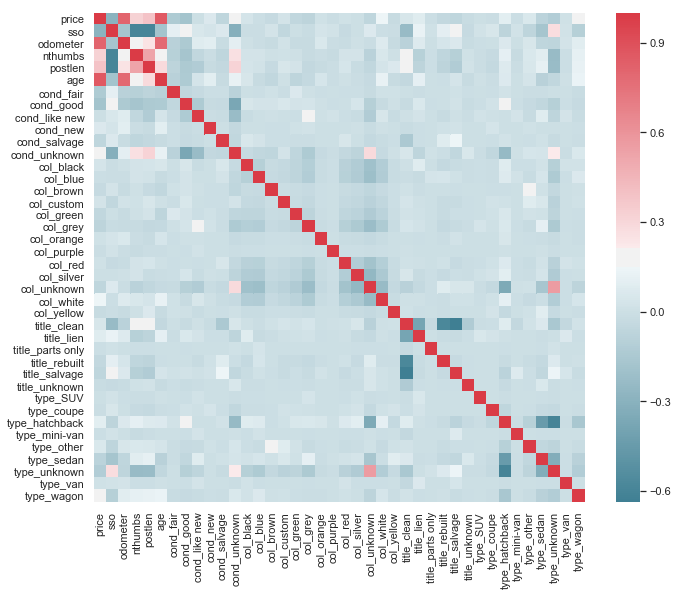

[(0.8617545032348078, 'cond_fair'), (0.8145673399247495, 'nthumbs'), (0.39115616518093366, 'age'), (0.3265565207532541, 'postlen'), (0.29523290041978323, 'odometer'), (0.18148790891422575, 'cond_like new'), (0.16626005744367345, 'col_black'), (0.14461017263066397, 'col_yellow'), (0.1343612969709305, 'cond_good'), (0.11623754298937274, 'type_van')]


States of interest:


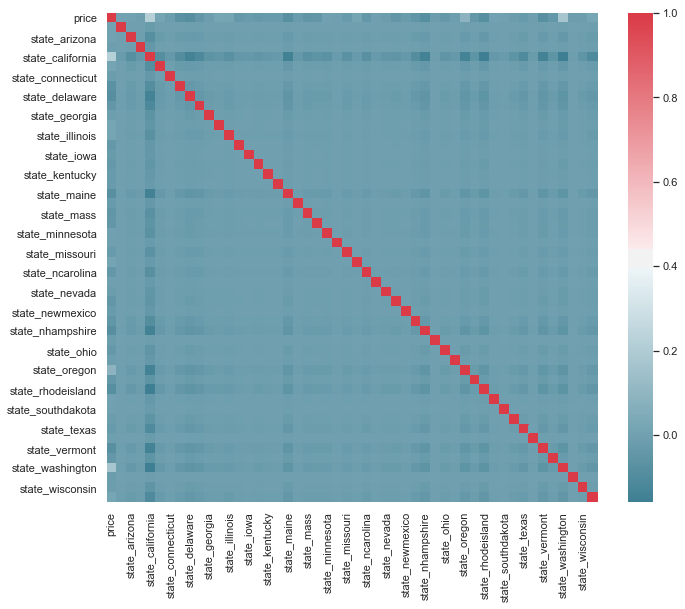

[(0.21970331081214298, 'state_colorado'), (0.16681729659928218, 'state_westvirginia')]


Cities of interest:


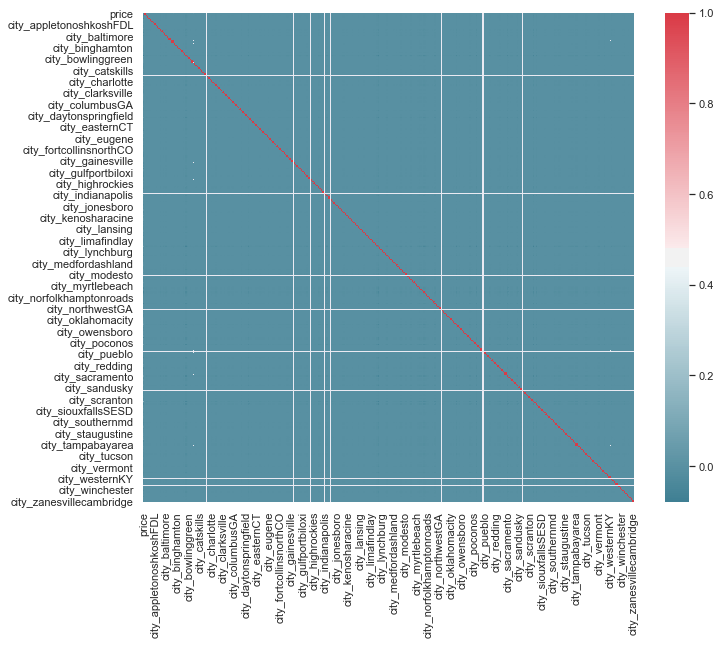

[(0.1640281309443108, 'city_sheboygan')]


In [12]:
def top_correlations(df, cols, save=False):
    X = df[['price'] + cols]
    c = X.corr()
    corr = c['price'][1:]

    corr = corr.apply(abs)
    corr = zip(corr, cols[1:])
    corr = sorted(corr, reverse = True)
    corr = filter(lambda x: x[0] > .1, corr)
    
    # Plot corr
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(c, cmap=cmap)
    plt.show()
    if save:
        f.savefig(save, format = 'svg')
    
    return list(corr)

print("Original features:")
print(top_correlations(play_df, original_feats))
print("\n")
print("States of interest:")
print(top_correlations(play_df, states_of_int))
print("\n")
print("Cities of interest:")
print(top_correlations(play_df, cities_of_int))

In [13]:
def train_model(df, cols, clf):
    '''Given a df, cols of interest, and a classifier object,
    run 5-fold CV and return both rmse and related score for clf'''
    
    X = df[cols]
    y = df['price']
    
    kf = model_selection.KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X)
    clf_scores = []
    rmse = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        
        scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        clf.fit(X_train,y_train)
        preds = clf.predict(X_test)
        rmse = np.sqrt(mean_squared_error(preds, y_test))
        score = clf.score(X_test, y_test)
        clf_scores.append(score)
    mean_rmse = np.mean(rmse)
    mean_score = np.mean(score)
    
    print('5-fold rmse:', mean_rmse)
    print('5-fold clf score:', mean_score)
    
    return clf

In [14]:
def sort_coef_feat(coefs, features, f=False, reverse=True):
    '''Given the coefficients and set of features, return a sorted list
    
    f: is a lambda expression used to filter coef values'''
    coefs = np.abs(coefs)
    pairs = zip(coefs, features)
    pairs = sorted(pairs, key = lambda x: x[0], reverse=reverse)
    if f:
        pairs = list(filter(f, pairs))
    print("Ranked features-pvals:")
    print(pairs)
    return pairs
    

In [15]:
# Try ranking by pval for F score, return top list of cols

def f_rank(df, cols):    
    X = df[cols]
    y = df['price']

    f = lambda x: x[0] < 0.001
    F,pval = feature_selection.f_regression(X, y, center=True)
    pairs = sort_coef_feat(pval, cols, f=f, reverse=False)
    return [x[1] for x in pairs]

top_all = f_rank(play_df, original_feats + states_of_int + cities_of_int)

Ranked features-pvals:
[(0.0, 'odometer'), (0.0, 'postlen'), (0.0, 'age'), (1.409514161225257e-228, 'nthumbs'), (2.9265601843139995e-185, 'sso'), (2.045790213222733e-101, 'state_california'), (1.1105708687294711e-72, 'type_wagon'), (2.8715387754557477e-69, 'cond_good'), (1.17048260921404e-58, 'state_washington'), (2.8368290802843465e-58, 'cond_unknown'), (2.2536875630857684e-44, 'col_white'), (1.7185586089614987e-38, 'cond_fair'), (3.599337919982798e-29, 'type_unknown'), (4.8257738729358687e-20, 'type_hatchback'), (3.8603041704205287e-17, 'state_oregon'), (4.2000428414704275e-16, 'state_rhodeisland'), (1.2458400679880727e-15, 'title_lien'), (6.769839677073451e-15, 'state_delaware'), (1.1084648740219216e-14, 'state_nhampshire'), (9.841646382668253e-14, 'type_sedan'), (1.2170901289664596e-12, 'state_vermont'), (1.3393479265726139e-12, 'state_maine'), (3.472024604776815e-11, 'col_grey'), (4.257724288135998e-11, 'state_dc'), (3.4699610911939803e-10, 'cond_new'), (1.8913074205249205e-08, 'c

/Users/amhoang/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/amhoang/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amhoang/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amhoang/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [17]:
# Do a quick linear model with regressors of interest
# cols_of_int = ['age', 'odometer', 'postlen', 'nthumbs', 'sso', 'type_wagon', 'cond_good',
#                'cond_unknown', 'col_white', 'cond_fair', 'type_unknown',
#                'state_california', 'state_washington', 'city_seattletacoma']
import patsy

all_cols = original_feats + states_of_int + cities_of_int
cols_of_int = top_all
linear = LinearRegression()

linear = train_model(play_df, cols_of_int, linear)
coef = linear.coef_
# sort_coef_feat(coef, cols_of_int)

base = 'price ~ '
formula = base + 'age'
formula_all = ''

for col in all_cols:
    formula_all += 'Q("' + col + '") + '
    
r_squared = []
sig_feat = []
for col in all_cols:
    y, X = patsy.dmatrices(base + 'Q("' + col + '")', data = play_df, return_type='dataframe')
    sm_model = sm.OLS(y, X)
    fit = sm_model.fit()
    pval = fit.pvalues[1]
    r2 = fit.rsquared
    if pval < 0.01:
        sig_feat.append(col)
        r_squared.append(r2)
        
    f = lambda x: x[0] > 0.02

sort_coef_feat(r_squared, sig_feat, f=f)

5-fold rmse: 2016.6401749135855
5-fold clf score: 0.8514700489854129


/Users/amhoang/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/amhoang/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/amhoang/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/amhoang/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Ranked features-pvals:
[(0.7426208238454342, 'age'), (0.663519951272102, 'odometer'), (0.15300314555905226, 'postlen'), (0.10663916124647677, 'nthumbs'), (0.08716246549028794, 'sso'), (0.04826954478182188, 'state_california'), (0.03457620948367213, 'type_wagon'), (0.03293786108205432, 'cond_good'), (0.027828010444691076, 'state_washington'), (0.02764240670117124, 'cond_unknown'), (0.02690522774108317, 'city_seattletacoma'), (0.02091210202826832, 'col_white')]


[(0.7426208238454342, 'age'),
 (0.663519951272102, 'odometer'),
 (0.15300314555905226, 'postlen'),
 (0.10663916124647677, 'nthumbs'),
 (0.08716246549028794, 'sso'),
 (0.04826954478182188, 'state_california'),
 (0.03457620948367213, 'type_wagon'),
 (0.03293786108205432, 'cond_good'),
 (0.027828010444691076, 'state_washington'),
 (0.02764240670117124, 'cond_unknown'),
 (0.02690522774108317, 'city_seattletacoma'),
 (0.02091210202826832, 'col_white')]

/Users/amhoang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


5-fold rmse: 1383.3611163613555
5-fold clf score: 0.9349454605921661
[(0.6957641768523295, 'age'), (0.18420050817316988, 'odometer'), (0.07435320914121536, 'postlen'), (0.023090189733950574, 'nthumbs'), (0.005609752372001711, 'state_california'), (0.004527704265684637, 'cond_unknown')]


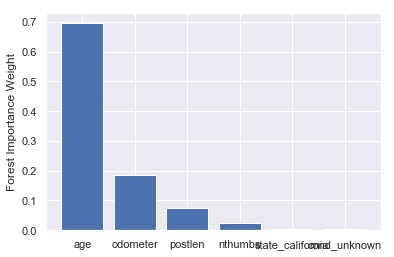

In [18]:
# Play with RandomForestRegressor to peak at top feature importances
# as an intuition check. Train this through 5-fold CV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

cols_of_int = ['age', 'odometer', 'postlen', 'nthumbs', 'sso', 'state_california', 'cond_good', 'type_wagon',
              'state_washington', 'city_seattletacoma', 'cond_unknown']

X = play_df[cols_of_int]
y = play_df['price']

forest = RandomForestRegressor(n_estimators=30)
train_model(play_df, cols_of_int, forest)

pairs = list(zip(forest.feature_importances_, X.columns))
pairs = sorted(pairs, reverse=True)
pairs = list(filter(lambda x: x[0] > .001, pairs))
pairs = pairs[:6]

print(pairs)

importances = [x[0] for x in pairs]
features = [x[1] for x in pairs]
x_pos = np.arange(len(features)) 

plt.bar(x_pos, importances,align='center')
plt.xticks(x_pos, features) 
plt.ylabel('Forest Importance Weight')
plt.show()

In [19]:
# Try ElasticNet with GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler

l1_ratio = np.linspace(.75, .95, 20)
alphas = np.linspace(.01, .02, 10)

param_grid = {'alpha': alphas,
             'l1_ratio': l1_ratio}

X = play_df[cols_of_int]
y = play_df['price']

regr = ElasticNet()
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)

grid = GridSearchCV(regr, param_grid)
grid.fit(X,y)

g_scores = grid.grid_scores_
for g in g_scores:
    print(g)

/Users/amhoang/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/amhoang/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


mean: 0.82607, std: 0.00586, params: {'alpha': 0.01, 'l1_ratio': 0.75}
mean: 0.82607, std: 0.00586, params: {'alpha': 0.01, 'l1_ratio': 0.7605263157894737}
mean: 0.82607, std: 0.00586, params: {'alpha': 0.01, 'l1_ratio': 0.7710526315789473}
mean: 0.82607, std: 0.00586, params: {'alpha': 0.01, 'l1_ratio': 0.781578947368421}
mean: 0.82607, std: 0.00586, params: {'alpha': 0.01, 'l1_ratio': 0.7921052631578948}
mean: 0.82607, std: 0.00586, params: {'alpha': 0.01, 'l1_ratio': 0.8026315789473684}
mean: 0.82606, std: 0.00586, params: {'alpha': 0.01, 'l1_ratio': 0.8131578947368421}
mean: 0.82606, std: 0.00586, params: {'alpha': 0.01, 'l1_ratio': 0.8236842105263158}
mean: 0.82606, std: 0.00586, params: {'alpha': 0.01, 'l1_ratio': 0.8342105263157895}
mean: 0.82606, std: 0.00586, params: {'alpha': 0.01, 'l1_ratio': 0.8447368421052631}
mean: 0.82606, std: 0.00586, params: {'alpha': 0.01, 'l1_ratio': 0.8552631578947368}
mean: 0.82606, std: 0.00586, params: {'alpha': 0.01, 'l1_ratio': 0.8657894736842

In [20]:
# With near optimal values at alpha = 0.0094 and l1_ratio = 0.9278, construct ElasticNet
# Note these values will change if the train data is shuffled, but generally low alpha
# and high l1_ratio will assist, especially with zero out features in regularization

# We iterate through ElasticNet to see which values with small coefs can be qualitatively
# discarded
from sklearn.linear_model import ElasticNetCV

cols_of_int = ['age', 'odometer', 'postlen', 'nthumbs', 'sso', 'state_california', 'cond_good', 'type_wagon',
              'state_washington', 'city_seattletacoma']

elastic = ElasticNet(alpha = 0.01842105263157895, l1_ratio=0.9078947368421052)
elastic = train_model(play_df, cols_of_int, elastic)
coef = elastic.coef_
coef = np.abs(coef)
pairs = zip(coef, X.columns)
pairs = sorted(pairs, reverse=True)
print(pairs)

5-fold rmse: 2237.8051950043637
5-fold clf score: 0.8171597459187958
[(2772.2401183988754, 'age'), (1713.3832476815294, 'odometer'), (441.4228568810613, 'nthumbs'), (377.22962517619646, 'postlen'), (340.42022398997784, 'type_wagon'), (297.93380175593717, 'state_california'), (149.33910832778068, 'city_seattletacoma'), (146.49846874283094, 'state_washington'), (135.94938583132233, 'cond_good'), (116.8044409404045, 'sso')]


In [63]:
# Evaluate final model candidates with patsy and statsmodel:

from scipy.stats import norm

def model_scoring(cols_of_int, summary=False):
    '''Given some features of interest, do 5-fold CV and return model scores'''
    formula = 'price ~ '
    formula += ' + '.join(cols_of_int)
    formula = formula[:-8]
    
    X = split_data[cols_of_int]
    X.reset_index(inplace=True)
    try:
        X['odometer'] = X['odometer'].apply(float)
    except:
        # No odometer features
        pass

    kf = model_selection.KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X)
    rsquared_adj = []
    rmses = []
    deviances = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        
        try:
            # Store these odometer transformation values from train data
            # to transform test later
            odo_mean = X_train['odometer'].mean()
            odo_sd = X_train['odometer'].std()

            X_train['odometer'] = (X_train['odometer'] - odo_mean)/odo_sd
            X_train['odometer'] = np.exp(-1*X_train['odometer'])
        except:
            # No odometer features
            pass
        
        # Create scaler based only on train data
        scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
        scaler.fit(X_train)
        X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)

        try:
            X_test['odometer'] = (X_test['odometer'] - odo_mean)/odo_sd
            X_test['odometer'] = np.exp(-1*X_test['odometer'])
        except:
            # No odometer features
            pass
        
        X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
        y_tr, X_tr = patsy.dmatrices(formula, data = X_train, return_type='dataframe')
        sm_model = sm.OLS(y_tr, X_tr)
        fit = sm_model.fit()

        # Prepare test matrix for prediction and comparison
        y_true, X_te = patsy.dmatrices(formula, data = X_train, return_type='dataframe')

        # Predictions
        y_preds = fit.predict(X_te)

        y_true = np.array(y_true).flatten()
        y_preds = np.array(y_preds)

        # Calculate out-of-sample deviance (model only gives in-sample estimates)
        out_SSE = np.sum(np.square(y_true - y_preds))
        out_std = np.sqrt(out_SSE/len(y_preds))
        log_density = pd.DataFrame()
        log_density['y_true'] = y_true
        log_density['y_preds'] = y_preds
        log_density.loc[:,'std'] = out_std
        log_density['likelihood'] = log_density.apply(lambda row: norm.logpdf(\
                        row['y_true'], row['y_preds'], row['std']), axis=1)
        deviance = -2*sum(log_density['likelihood'])
        deviances.append(deviance)

        # Calculate rmse
        rmse = np.sqrt(mean_squared_error(y_true, y_preds))
        rmses.append(rmse)

        # Append adjusted rsquared
        rsquared_adj.append(fit.rsquared_adj)
        
        if summary:
            print(fit.summary())
        
    return np.mean(deviances), np.mean(rmses), np.mean(rsquared_adj)
    
features1 = ['age', 'odometer', 'nthumbs', 'sso', 'state_california', 'cond_good', 'type_wagon',
    'state_washington', 'city_seattletacoma', 'price']
features2 = ['age', 'odometer', 'postlen', 'nthumbs', 'sso', 'state_california', 'cond_good', 'type_wagon',
    'state_washington', 'price']
features3 = ['age', 'odometer', 'nthumbs', 'sso', 'state_california', 'cond_good', 'type_wagon', 'price']
features4 = ['age', 'odometer', 'nthumbs', 'sso', 'state_california', 'cond_good', 'price']
features5 = ['age', 'odometer', 'nthumbs', 'sso', 'state_california', 'price']
features6 = ['age', 'odometer', 'nthumbs', 'sso', 'price']
features7 = ['age', 'odometer', 'nthumbs', 'price']
features8 = ['age', 'odometer', 'price']

features9 = ['age', 'odometer', 'nthumbs', 'sso', 'state_california', 'type_wagon',
    'state_washington', 'price']

m1 = model_scoring(features1)
m2 = model_scoring(features2)
m3 = model_scoring(features3)
m4 = model_scoring(features4)
m5 = model_scoring(features5)
m6 = model_scoring(features6)
m7 = model_scoring(features7)
m8 = model_scoring(features8)
m9 = model_scoring(features9)

/Users/amhoang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/amhoang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/amhoang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

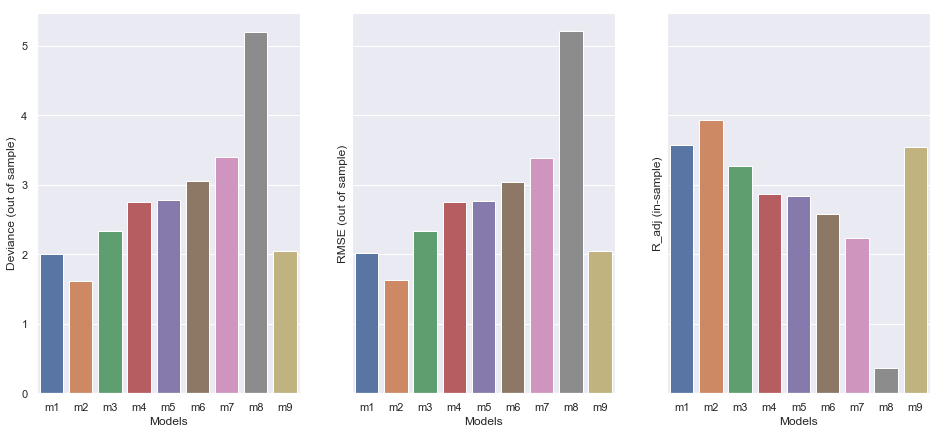

In [64]:
# Plot our final model

model_scores = {'m1': m1,
                'm2': m2,
                'm3': m3,
                'm4': m4,
                'm5': m5,
                'm6': m6,
                'm7': m7,
                'm8': m8,
                'm9': m9}

m_scores = pd.DataFrame(model_scores)
cols = list(m_scores.columns)

standard = lambda arr: 2.8 + (np.array(arr) - np.mean(arr))/np.std(arr)
deviances = m_scores.loc[0:0,:].values[0]
deviances = standard(deviances)
mse = m_scores.loc[1:1,:].values[0]
mse = standard(mse)
r_adj = m_scores.loc[2:2,:].values[0]
r_adj = standard(r_adj)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16,7))
sns.barplot(x= cols, y = deviances, ax=ax1)
sns.barplot(x= cols, y = mse, ax=ax2)
sns.barplot(x= cols, y = r_adj, ax=ax3)

ax1.set(xlabel = 'Models', ylabel="Deviance (out of sample)")
ax2.set(xlabel = 'Models', ylabel="RMSE (out of sample)")
ax3.set(xlabel = 'Models', ylabel="R_adj (in-sample)")

f.savefig('modelscores.svg', format='svg')

/Users/amhoang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/amhoang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/amhoang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:/

Elastic's in sample training r2: 0.8377924779340733
Elastic's out of sample, holdout r2: 0.832316064168783
[(-2529.0374158183263, 'age'), (2262.346161272339, 'odometer'), (445.3820349295943, 'nthumbs'), (-294.99325991496676, 'sso'), (305.0251196715516, 'state_california'), (298.37234086314635, 'type_wagon'), (265.2274071780803, 'state_washington')]


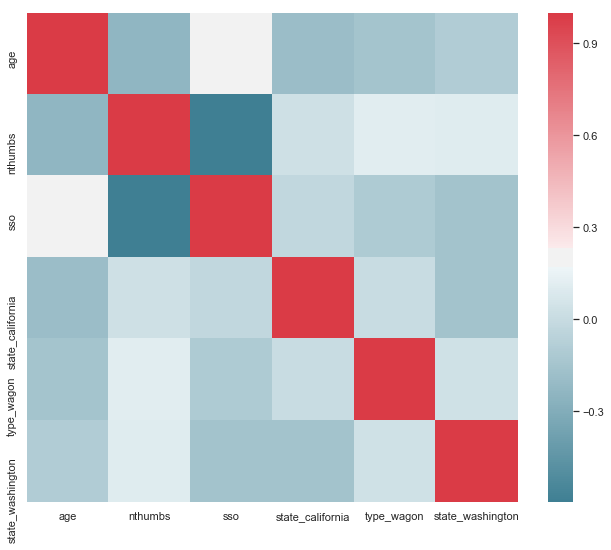

In [23]:
# Check the stats of our final model and run a final test on the holdout set
features9 = ['age', 'odometer', 'nthumbs', 'sso', 'state_california', 'type_wagon', 'state_washington']

X_train = split_data[features9]
y_train = split_data['price']
X_holdout = split_test[features9]
y_holdout = split_test['price']

corr = X_train.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap)
f.savefig('final_heatmap.svg', format = 'svg')

try:  
    X_train['odometer'] = X_train['odometer'].apply(float)
    X_holdout['odometer'] = X_holdout['odometer'].apply(float)

    odo_mean = X_train['odometer'].mean()
    odo_sd = X_train['odometer'].std()

    X_train['odometer'] = (X_train['odometer'] - odo_mean)/odo_sd
    X_train['odometer'] = np.exp(-1*X_train['odometer'])

    X_holdout['odometer'] = (X_holdout['odometer'] - odo_mean)/odo_sd
    X_holdout['odometer'] = np.exp(-1*X_holdout['odometer'])

except:
    pass

train_scale = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
train_scale.fit(X_train)
X_train = train_scale.transform(X_train)
X_holdout = train_scale.transform(X_holdout)

elastic = ElasticNet(alpha = 0.01842105263157895, l1_ratio=0.9078947368421052)
elastic.fit(X_train, y_train)
in_elastic_r2 = elastic.score(X_train, y_train)
out_elastic_r2 = elastic.score(X_holdout, y_holdout)

print("Elastic's in sample training r2:", in_elastic_r2)
print("Elastic's out of sample, holdout r2:", out_elastic_r2)
print(list(zip(elastic.coef_, features9)))

In [62]:
# Counterfactual predictions
# Input X is a list of values corresponding to:
# [age, odometer, nthumbs, sso, state_california, type_wagon, state_washington]

# From CL
x1 = [6, 200000., 6, 1, 1, 0, 0]
# From carfax
x2 = [5, 131927., 25, 0, 1, 0, 0]
# From carfax
x3 = [3, 32000., 20, 0, 0, 0, 1]

def guess_price(x, odo_mean, odo_sd, scaler, clf):
        x[1] = (x[1] - odo_mean)/odo_sd
        x[1] = np.exp(-1*x[1])
        x = scaler.transform([x])
        pred = clf.predict(x)
        print(pred)

guess_price(x1, odo_mean, odo_sd, train_scale, elastic)
guess_price(x2, odo_mean, odo_sd, train_scale, elastic)
guess_price(x3, odo_mean, odo_sd, train_scale, elastic)

[7929.62194838]
[10998.90465417]
[17828.24042797]
